## <span style="color:blue"> Computer Vision - Winter 2024

## <span style="color:blue"> Exercise 2 </span>
**Reichman University**

**Lecturer:** Prof. Yael Moses, RUNI

**TA:** Eyal Friedman, RUNI

**Submission date: 25.1.24** \
Note: In case you need an extension for any reason, you can submit it by 29.1.24. \
No extra extensions will be given.
In case you are in miluim - please contact Yael directly.

**Your name: [Your Name]**
**Your ID: [Your ID]**

In this exercise, you will implement: 
    
1. Straight line detection from image features using  Hough Transform.
2. Various feature matching.
3. Computing depth from rectified images.


## <span style="color:blue"> Submission guidelines:</span>

1. Your **zip** file should include the following files only:
   - ex2.ipynb
   - images you use that were not given 
2. You should use Jupyter Notebook.
3. Name the zip file **'ex2_ID_ID.zip'** and **do not** include any additional directories.
4. Submit using *Moodle*.
5. Submit on time!
6. You can submit this assignment in pairs (no triplets).
   * In the case of pair submission, both IDs and names should be added to the notebook.
   * One should submit the homework, and the other should submit a simple text file named: ID_ID.txt and nothing else.
   *Please make sure that your collaborator submits the HW.

## Read the following instructions carefully:

1. Write **efficient vectorized** code. When you think you cannot use vectorized code, give a short explanation of why.
2. You are responsible for the correctness of your code and should add as many tests as you see fit. Do not submit your tests unless requested.
3. Use `Python 3` and `numpy 1.18.5` or above. Changes to the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden unless provided by us.
5. Your code must run without errors. Note, **Code that fails to run will not be graded.**
6. Document your code properly.
7. Go over Warmup Python - you can find relevant python functions that will make your life easier.



## Honor Code:
The assignment is a basic tool for learning the material. You can probably find the solution on the web (including ChatGPT), however, you will not learn what you should learn from it. In addition, since we give grades on the assignment, using existing solutions will be considered dishonest.
In particular, you are not allowed to copy or use any code that solve the tasks. 
You are more than welcome to talk with your friends, but you are not allowed to give your code or answers and you are not allowed to use their code or answers. 
Remember – you take this course in order to learn.

## I declair that I respcet the honor code:
<span style="color:red"> Add here your names: 


In [123]:
import cv2
from varname import nameof

from matplotlib import pyplot as plt

# This opens an inteactive figure - use it in part B
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space

# This specifies the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'


import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.10.11
Numpy version:  1.23.5




## <span style="color:blue">Section A: Detect a Straight Lines

In this part you will use the set of edge points to detect straight lines in an image.\
The input will consist of edge points computed by the Canny edge detector - you can use the implementation of CV2, which is demonstrated below.\
    The output will be a set of straight lines in the image. There are two main methods to compute straight lines from such input: the Hough transform and RANSAC. You will implement the Hough transform.

    

**Hough transform**\
Every 2D line, $\ell$,   can be represented by 2 parameters:  $r$ and $\theta$ where all points on the lines satisfy $r=(xcos\theta, ysin\theta)$. 
Let $P_0=(x_0,y_0)$ be the intersection of a normal to $\ell$ from the origin.
The distance between $P_0$ and the origin is given by $r$ and the angle between the normal and the $x$ axis is given by $\theta$. 






**Your goal:**     Write the following function\
Straight_lines(image_file, res_r, res_orient,min_number_points,display,  ...)\
    You can add any other parameters that you need.
    


 To do so, you need also to define the following functions. 
 You can add parameters to the functions, as long as you  provide clear explanations of their roles and purposes.

image.shape =  (1053, 1053)
display image


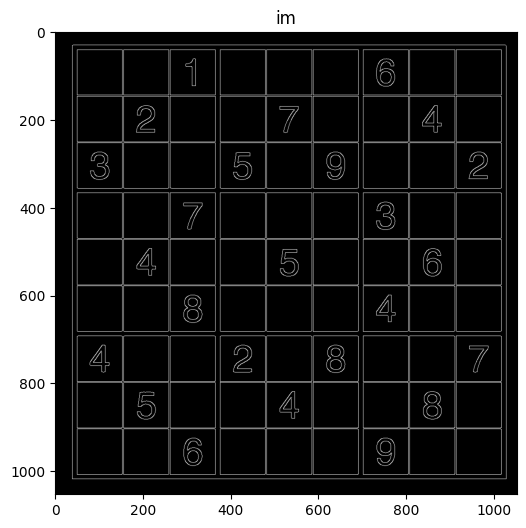

TypeError: Image data of dtype object cannot be converted to float

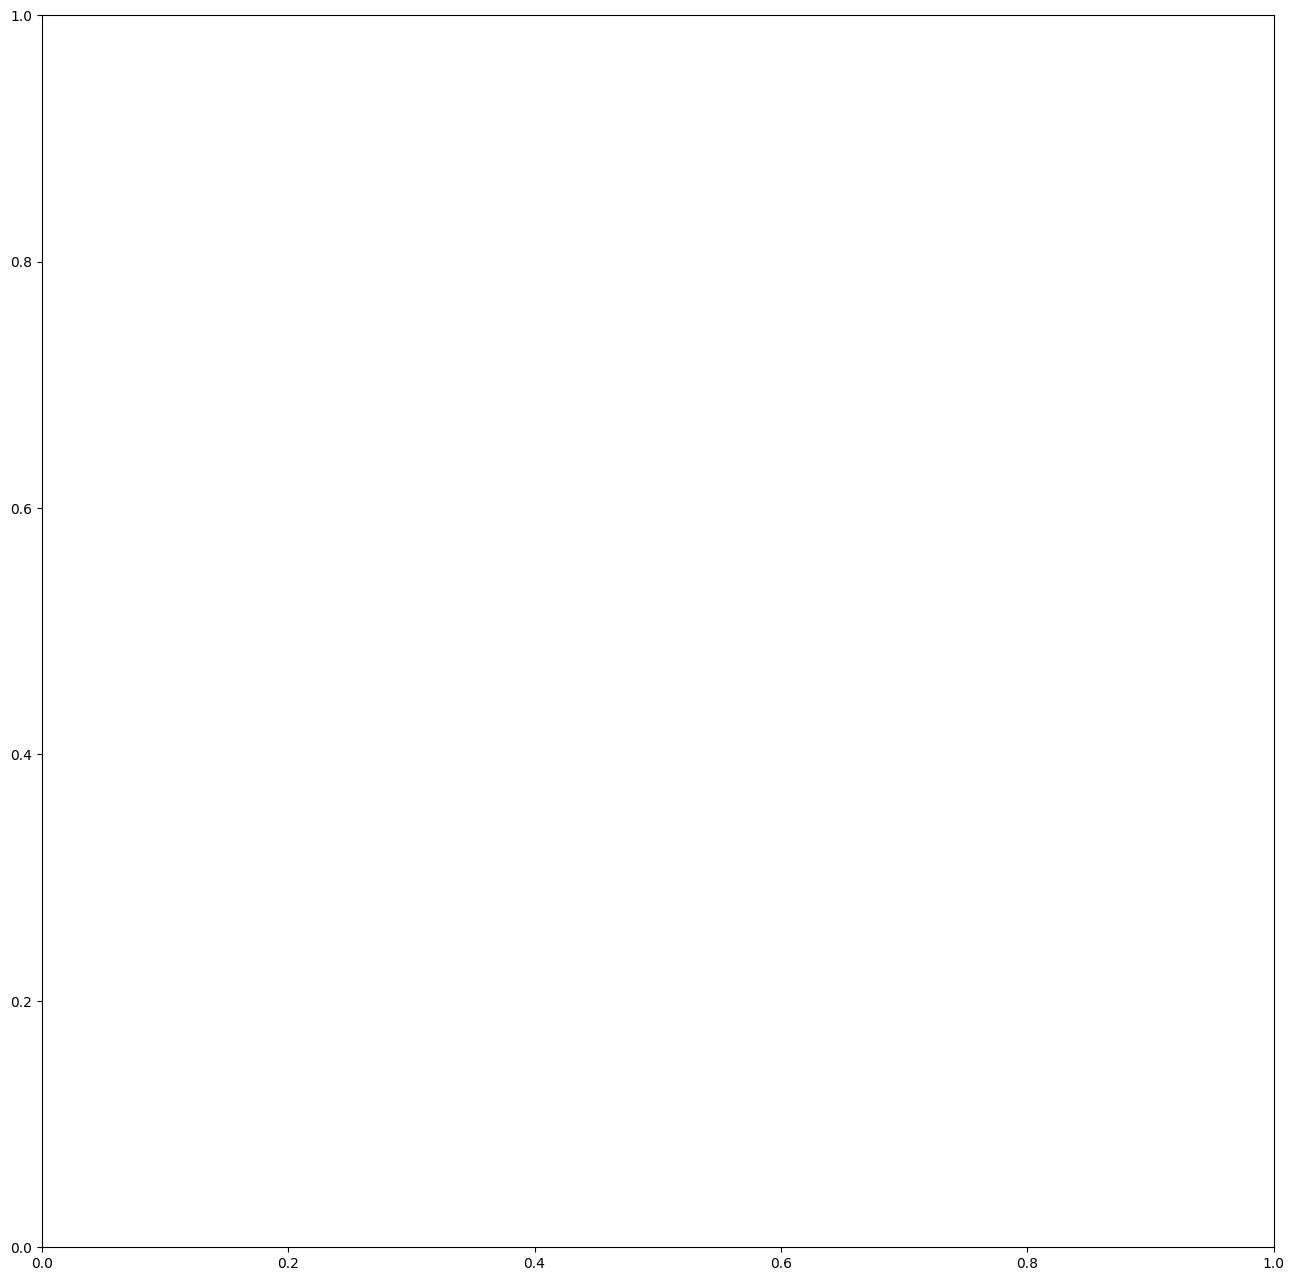

In [184]:
def H_matrix(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """hough line using vectorized numpy operations,
    may take more memory, but takes much less time"""
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step)) #can be changed
    #width, height = col.size  #if we use pillow
    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_theta = np.cos(thetas)
    sin_theta = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas))
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    #are_edges = cv2.Canny(img,50,150,apertureSize = 3)
    y_idxs, x_idxs = np.nonzero(are_edges)  # (row, col) indexes to edges
    # Vote in the hough accumulator
    xcosthetas = np.dot(x_idxs.reshape((-1,1)), cos_theta.reshape((1,-1)))
    ysinthetas = np.dot(y_idxs.reshape((-1,1)), sin_theta.reshape((1,-1)))
    rhosmat = np.round(xcosthetas + ysinthetas) + diag_len
    rhosmat = rhosmat.astype(np.int16)
    for i in range(num_thetas):
        rhos,counts = np.unique(rhosmat[:,i], return_counts=True)
        accumulator[rhos,i] = counts
    return accumulator, thetas, rhos




# Input: The Hough matrix $H$, and a threshold for the number of minimal points on the line.
# output a list of triplets:  $(r, \Theta, num_points)$ where
# num_points is the number of points on that line.

def  list_lines(H,th):
    list_lines = []
    for r in range(H.shape[0]):
        for theta in range(H.shape[1]):
            if H[r,theta] > th:
                list_lines.append([r, theta, H[r,theta]])
    return list_lines

# Display the detected lines in red - overlaid the original image
# Note: one way to do is, is to add the red lines to the image, and then display it
def display_lines(im,list_lines):
    for line in list_lines:
        r = line[0]
        theta = line[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*r
        y0 = b*r
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(im,(x1,y1),(x2,y2),(0,0,255),2)
    plt.figure(figsize=(6, 6))
    plt.imshow(im)
    plt.show()


def display_H_matrix(H):
    # stretched_image = stretch_image(H, 10, 1)
    plt.imshow(H, cmap='gray')
    plt.xlabel('Theta (degrees)')
    plt.ylabel('R')
    plt.title('Hough Matrix for ' + nameof(H))
    plt.colorbar(label='Votes')
    plt.show()

def stretch_image(image, width_factor, height_factor):
    height, width = image.shape[:2]
    new_width = int(width * width_factor)
    new_height = int(height * height_factor)
    stretched_image = cv2.resize(image, (new_width, new_height))
    return stretched_image

def display_image(im):
        plt.figure(figsize=(6, 6))
        plt.imshow(im, cmap='gray')
        plt.title(nameof(im))
        plt.show()

def create_toy_image(size, L_points):
    dimx, dimy = size, size
    # img_2, img_3 = np.random.randint(0, 256, size=(dimx, dimy), dtype=np.uint8), np.random.randint(0, 256, size=(dimx, dimy), dtype=np.uint8)
    img_2 = np.full((dimx, dimy), 0)
    # place the points on the image
    for point in L_points:
        img_2[point[0], point[1]] = 255
    
    return img_2

def create_line_points(size_param):
    L_line_points = []
    for i in range(size_param):
        if i < size_param // 5:
            L_line_points.append([i*2, i])
        elif i < 2 * (size_param // 8):
            L_line_points.append([i*2, size_param // 3])
        else:
            L_line_points.append([i, size_param - i])
    return np.array(L_line_points)

def find_max_points(matrix):
    indices = np.argwhere(matrix == np.max(matrix))
    max_points = [(matrix[idx[0], idx[1]], idx[1], idx[0]) for idx in indices]
    max_points.sort(reverse=True)
    return max_points

def get_points_above_threshold(matrix, threshold):
    indices = np.argwhere(matrix > threshold)
    return np.array([(idx[1], idx[0]) for idx in indices])

size_param = 200
# L_points = np.random.randint(0, size_param, size=(size_param, 2))
L_line_points = create_line_points(size_param)
toy_image = create_toy_image(size_param, L_line_points)

img = cv2.imread('Sudoku.PNG')
edges = cv2.Canny(img,250,500,5)
image = edges
print("image.shape = ", image.shape)
print("display image")
display_image(image)


resolution_r = 0.1
resolution_ang = 0.1
H_test = H_matrix(image, resolution_r, resolution_ang)
display_H_matrix(H_test)

print("max points are: ")
print(find_max_points(H_test)[0:50])

list_lines_test = list_lines(H_test, 10)
print("list_lines_test = ", list_lines_test)
print("display lines")
display_lines(toy_image, list_lines_test)
# H_test2 = H_matrix(edges, 0.1, 0.01)
# display_H_matrix(H_test2)


image.shape =  (1053, 1053)
display image


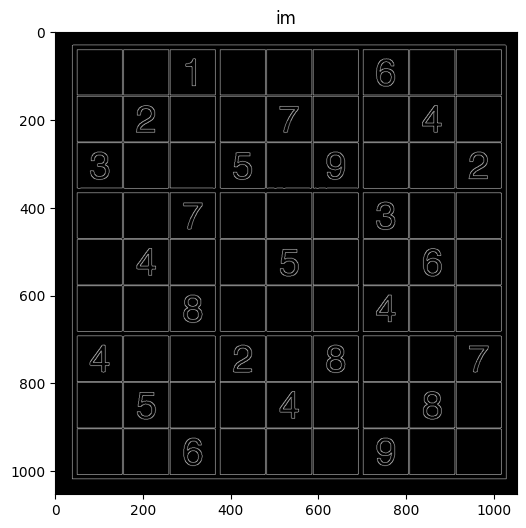

L_points.shape =  (1053, 1053)
max_distance =  1489
params_mat.shape =  (2978, 1800)


KeyboardInterrupt: 

In [180]:
# Input: a set of edge points (or corners), and the resolution of the distance and angles. 
# output: the Hough matrix (H) containing votes for lines represented by r and θ.

def  H_matrix(edges, resolution_r, resolution_ang):
    print("image.shape = ", image.shape)
    max_distance = int(round(np.sqrt(np.square(edges.shape[0]) + np.square(edges.shape[1])).max()))
    print("max_distance = ", max_distance)
    thetas = np.deg2rad(np.arange(-90.0, 90.0, resolution_ang))
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    edges_only = edges > 100
    y_s, x_s = np.nonzero(edges_only)
    params_mat = np.zeros((2*max_distance, len(thetas)), dtype=np.uint8)
    print("params_mat.shape = ", params_mat.shape)
    for i in range(len(x_s)):
        x = x_s[i]
        y = y_s[i]
        for t_idx in range(num_thetas):
            rho = max_distance + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            params_mat[rho, t_idx] += 1

    # with np.printoptions(threshold=np.inf): print("params_mat = ", params_mat)
    
    return params_mat


# Input: The Hough matrix $H$, and a threshold for the number of minimal points on the line.
# output a list of triplets:  $(r, \Theta, num_points)$ where
# num_points is the number of points on that line.

def  list_lines(H,th):
    list_lines = []
    for r in range(H.shape[0]):
        for theta in range(H.shape[1]):
            if H[r,theta] > th:
                list_lines.append([r, theta, H[r,theta]])
    return list_lines

# Display the detected lines in red - overlaid the original image
# Note: one way to do is, is to add the red lines to the image, and then display it
def display_lines(im,list_lines):
    for line in list_lines:
        r = line[0]
        theta = line[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*r
        y0 = b*r
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(im,(x1,y1),(x2,y2),(0,0,255),2)
    plt.figure(figsize=(6, 6))
    plt.imshow(im)
    plt.show()

# def display_H_matrix(H):
#         # plt.figure(figsize=(6, 6))
#         plt.imshow(H, cmap='gray')
#         plt.xlabel('Theta')
#         plt.ylabel('R')
#         plt.title('Hough Matrix for ' + nameof(H))
#         plt.figure(figsize=(400, 100))
#         plt.show()

def display_H_matrix(H):
    # stretched_image = stretch_image(H, 10, 1)
    plt.imshow(H, cmap='gray')
    plt.xlabel('Theta (degrees)')
    plt.ylabel('R')
    plt.title('Hough Matrix for ' + nameof(H))
    plt.colorbar(label='Votes')
    plt.show()

def stretch_image(image, width_factor, height_factor):
    height, width = image.shape[:2]
    new_width = int(width * width_factor)
    new_height = int(height * height_factor)
    stretched_image = cv2.resize(image, (new_width, new_height))
    return stretched_image

def display_image(im):
        plt.figure(figsize=(6, 6))
        plt.imshow(im, cmap='gray')
        plt.title(nameof(im))
        plt.show()

def create_toy_image(size, L_points):
    dimx, dimy = size, size
    # img_2, img_3 = np.random.randint(0, 256, size=(dimx, dimy), dtype=np.uint8), np.random.randint(0, 256, size=(dimx, dimy), dtype=np.uint8)
    img_2 = np.full((dimx, dimy), 0)
    # place the points on the image
    for point in L_points:
        img_2[point[0], point[1]] = 255
    
    return img_2

def create_line_points(size_param):
    L_line_points = []
    for i in range(size_param):
        if i < size_param // 5:
            L_line_points.append([i*2, i])
        elif i < 2 * (size_param // 8):
            L_line_points.append([i*2, size_param // 3])
        else:
            L_line_points.append([i, size_param - i])
    return np.array(L_line_points)

def find_max_points(matrix):
    indices = np.argwhere(matrix == np.max(matrix))
    max_points = [(matrix[idx[0], idx[1]], idx[1], idx[0]) for idx in indices]
    max_points.sort(reverse=True)
    return max_points

def get_points_above_threshold(matrix, threshold):
    indices = np.argwhere(matrix > threshold)
    return np.array([(idx[1], idx[0]) for idx in indices])

size_param = 200
# L_points = np.random.randint(0, size_param, size=(size_param, 2))
L_line_points = create_line_points(size_param)
toy_image = create_toy_image(size_param, L_line_points)

image = edges
print("image.shape = ", image.shape)
print("display image")
display_image(image)


resolution_r = 0.1
resolution_ang = 0.1
H_test = H_matrix(image, resolution_r, resolution_ang)
display_H_matrix(H_test)

print("max points are: ")
print(find_max_points(H_test)[0:50])

list_lines_test = list_lines(H_test, 10)
print("list_lines_test = ", list_lines_test)
print("display lines")
display_lines(toy_image, list_lines_test)
# H_test2 = H_matrix(edges, 0.1, 0.01)
# display_H_matrix(H_test2)



In [ ]:
#Now use the above functions to implement 
def straight_lines(image_file, res_r, res_orient,min_number_points,display,  ...)()
...

In [ ]:
# Here is an example of how to draw a red line
# between (x1, y1) and (x2, y2) on a gray level image, img
# The first step is to create a color image from img.

imC=np.dstack([img,img,img])   # a gray level image that is saved as a color image
cv2.line(img, (x1, y1), (x2, y2), (255,0,0), thickness)


(<matplotlib.image.AxesImage at 0x20d33249000>, Text(0.5, 1.0, 'Edge Image'))

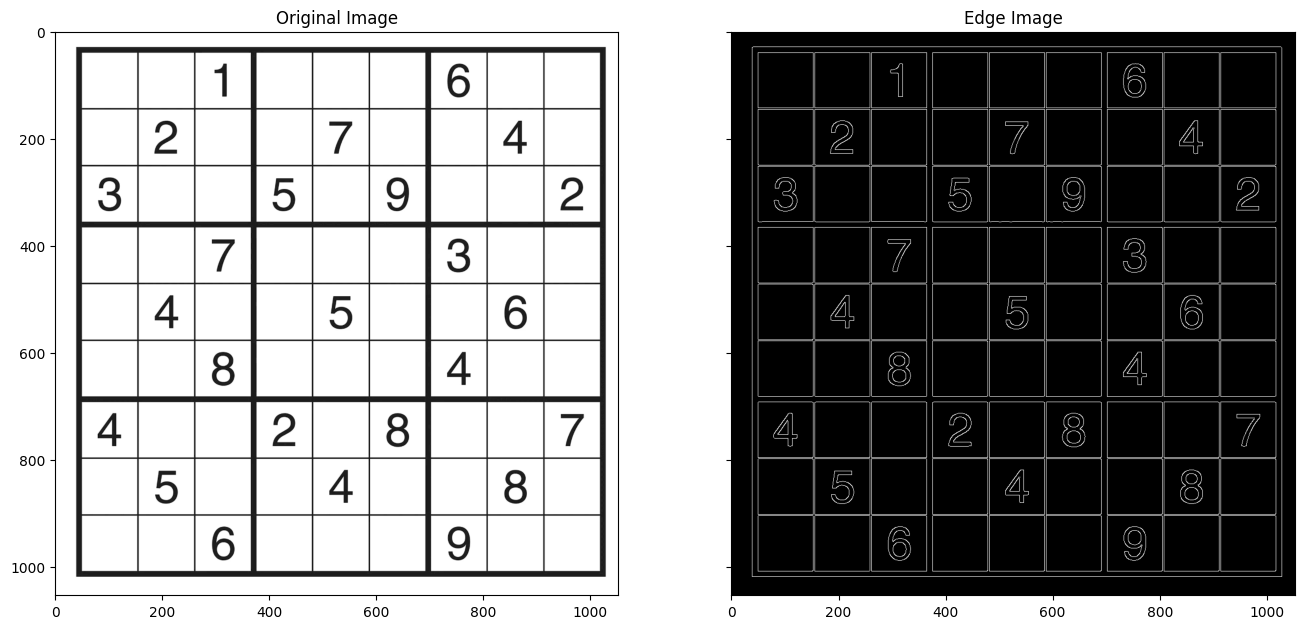

In [182]:
# Here is an example of how to use the CV2 Canny edge detector.
# You can play with the parameters to achieve desired results.
# Note that this implementation does not include smoothing with a Gaussian filter :(


img = cv2.imread('Sudoku.PNG', cv2.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

edges = cv2.Canny(img,250,500,5)

plt.rcParams['figure.figsize'] = (16.0, 16.0) 
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')

ax1.imshow(img), ax1.set_title('Original Image')
ax2.imshow(edges), ax2.set_title('Edge Image')


**Apply and answer**

1. Generate a synthetic image to test your Hough Transform algorithm. 
   * Submit the image as well as the results.


2. Apply your algorithm to the following images: Crosswalk, linesOnTheRoadGray, Sudoku. 
   * Choose a set of parameters so the results looks fine.
   * You may need different parameters for each image.
   * Display the results.
   
   
3. **Answer**: How the resolutions of $r$ and $\theta$ affect the results?
   * Display images that demonstarte your answer.
   
   
4. Choose one image and **answer**: how many straight lines did you find with more than 50 points?
   * Display these lines on the image.
   
   
5. Suggest an algorithm to compute the length of the line in the image.
   * Describe the algorithm without implementing it.
   
   
6. Suggest three applications to use the results of straight line detection in an image.



## <span style="color:blue">Section B: Patch Matching
**In this part you will match intrest points between two images.**
    
    
There are two functions between vectors $v$ and $u$ that you will consider:\
a. Distance: Sum of Square Distance (SSD). That is,  $SSD(u,v)=(u-v)\cdot(u-v)$.\
b. Similarity: Normalized Cross Correlation (NCC). That is,  $NCC(u,v)={u\cdot v \over ||u||||v||}$.


The patch descriptor:
1. A vector with the pixels' grey level.
2. An histogram (30 bins) of the pixels' grey level.
3. A vector with the pixels' strength gradient.
4. An histogram (30 bins) of the pixels' strength of gradient. 


In [ ]:
#Implement the following functions:

# Input: two vectors
# Output distance (scalar) between two patches

def  SSD(patch_descr_1, patch_descr_2) ()
...

# Input: two vectors
# Output normalized cross correlation  (scalar) between two patches

def NCC(patch_descr_1, patch_descr_2) ()
..

# Output a descriptor vector 
# im is an image, p is a pixel, size is the patch size.
# You can use the histogram function of open cv or numpy

def patch_from_im(im,p,size) ()
...

def hist_patch_im(im,p,size) ()
...

def  gradient(im,p,size) ()
...

def  hist_gradient(im,p,size) ()
...

**Apply and answer**


1. Compute the corners in a pair of images (e.g., view0.tif and view6.tif).


2. Choose up to 2000 of the strongest corners (you can use fewer) and find a matching between the corners in the pair of images.
    * Choose a fixed scale and use it to define a patch around each corner.
    * To display the matching, use the function cv2.hconcat([im1, im2]), which concatenates two images horizontally, and then draw lines as described in the previous section.


3. Use up to 4000 of the strongest corners (you can use fewer) in each image and use the matching only between corners that have approximately the same y-coordinate (up to a threshold).


4. Study the ratio for matching between the best and the second best match. 
   * You can use NCC or SSD on the desriptor of your choice.
   * You can use without (2) or with (3) the $y$-coordinate constraint.
   * **Present** examples that demonstrate the effectiveness of using the ratio.


5. Study the differences between the different descriptors and also the use of SSD or NCC. 
   * **Present**  examples that demonstrate your findings.


6. Identify incorrect pairs of matched points.\
   **Mark and display** for cases (2), (3), and (4) a pair of incorrectly matched points.\
   **Answer**\
   a. In which of the 3 cases are there more incorrect matches?\
   b. What may be the reason for the incorrect matches?


7. In which regions of the scene were most of the reliable matches found?



**Implementation details**

You can compute the NCC or SSD patch by patch. This will probably takes longer than using matrix multiplications of numpy.

Using matrices:
1. Generate a 1D vector from each descriptor.


2. Generate a matrix $M_1$:  rows  are  the descriptors of img1.


3. Generate a matrix $M_2$:  columns  are  the descriptors of img2.


4. $M=np.matmul(M_1,M_2)$\
   * what is the value in $M(i,j)$?


5. Think of how to normalize the set of patches, if you need.
   * You can consider using the function np.diag(np.diag(matrix)) as part of your solution.
    
    

## <span style="color:blue">Section C

In this part you will compute the 3D structure from a pair of rectified images.


**The input:**\
    **a.** A pair of two rectified images, $im1$ and $im2$ (*view1.png and view5.png*).\
    **b.** A window size $(s_x,s_y$).\
    **c.** Disparity range $(d_{min},d_{max})$ (see below).

**The output:**\
**a.** A matrix, $D$ with the disparity map for the left image.\
**b.** Three matrices X, Y, Z with the x, y, z-coordinates of each pixel in the left image. Assign zero for pixels for which the disparity was not computed.

Note: all matrices $im1, im2, D, X, Y, Z$ have the same dimensions.

**Instructions:**
1. Read the two images view1.png and view5.png, and apply the functions to this pair of images.

   
2. Write a function that receives two rectified images, and compute dense matching along lines with the same $y-$coordinate.
    * You can use any of the descriptors from Part B. The patch size should be given as a parameter.
    * Use NCC for the similarity measure.
    * You can assume that you are given the range of disparities, $d_{min},d_{max}$ as an input. \
      For example, if  $(d_{min},d_{max})=(20,120)$ it follows that the corresponding point of  $(x,y)$ in the left image, is in the range $(x-120:x-20,y)$ in the right image.
    * Consider matching with and without order preseving. 
    * List all parameters you use for your function.
    * Hints on efficient implementation is given below.
    
        
3. Write a function that computes the disparity based on (2).  
    * **Display** the disparity $D$ map as an image
   
  
4. Compute the depth map using the disparity.
    * Assume that scaled focal lengths ($f$ in the presentation) are $α_x=α_y=1$.
    * The distance between the cameras is 160mm.
    * Add to your disparity depth map the value 100, since images were cropped. 
    * Display the disparity as an image. 
   

4. Compute the matrices X,Y,Z
    * Present the object given by X,Y,Z using a 3D plot.


**Implementation**\
You can implement the computation of the similarity and the disparity directly by an exhaustive search. You can also use the idea from Part B. A more efficeint and elegant way is described below. You are welcome to try, but you do not have to.


General idea for the **vectorized solution** (you will need to fill in the gaps):
* Let $w$ and $h$ we the width and the height of the image respectively.
* First assume that the patch size is $1\times s_y$.
* Given two $1\times w$ rows, $r_1$ and $r_2$ which are corresponding rows of the two images. Compute the $w\times w$ matrix $R12=r_1^T r_2$. The values $R12(i,j)$ consists of the product of two pixels $r_1(i)\cdot r_2(j)$.
* Convolve $R12$ with the $s_y\times s_y$ identity matrix, $I_{s_y}$ : $Corr=I_{s_y}*R12$. The value $Corr(i,j)$ is the correlation of the $s_y$ 1D neighborhood of $r_1(i)$ and  $r_2(j)$.
* Think about how to normalize this correlation using the same idea. Hint, use the computation of $I_{s_y}*(r_1^Tr_1)$ and $I_{s_y}*(r_2^Tr_2)$.
* For a general patch size, $s_x\times s_y$, define $R$ to be 3D matrix of size $h\times w\times s_x$ and use 3D mask for the convolution.
* Up to here, we considered each row seperately, hence we need to loop over all rows of the images. There is a way to do it without looping, but not in this assignemnt :)
